# Importation des bibliothèques pour AdaBoost

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

2024-01-10 13:24:25.154498: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 13:24:25.442162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 13:24:25.442265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 13:24:25.493400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 13:24:25.603261: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 13:24:25.604719: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Configuration des paramétres

In [5]:
base_dir = "./Livrable 1"

In [6]:
#définir les dimensions

img_height = 50
img_width = 50
batch_size = 32

# Division en ensembles d'entraînement et de test

Cette cellule de code utilise la bibliothèque TensorFlow pour récupérer les données d'un répertoire spécifié. Les données sont ensuite divisées en ensembles d'entraînement (80%) et de test (20%)

In [7]:
#récupérer les données dans directory et les séparer en données d"entrainement (80%) et données de test (20%)

train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=  0.2,
  subset =  "both",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 41407 files belonging to 5 classes.
Using 33126 files for training.
Using 8281 files for validation.


# Conversion des données en tenseurs pour l'entraînement du modèle

Cette cellule de code extrait les images et les étiquettes (labels) de l'ensemble d'entraînement et de l'ensemble de test, les transformant en tenseurs pour être utilisés dans le processus d'entraînement du modèle. La fonction next(iter(...)) est employée pour obtenir un lot (batch) d'images et de labels à partir des ensembles correspondants, facilitant ainsi la manipulation de données sous forme de tenseurs dans le cadre du flux de travail d'apprentissage automatique.

In [8]:
#mettre les images et les labels dans des array qui sont des tensor

images_train, labels_train = next(iter(train_set))
images_test, labels_test = next(iter(test_set))

In [9]:
type(images_train)

tensorflow.python.framework.ops.EagerTensor

# Conversion des tenseurs en tableaux NumPy

Cette cellule de code effectue une conversion des tenseurs contenant les images d'entraînement et de test en tableaux NumPy. Cette transformation permet de manipuler plus aisément les données dans le cadre de certaines opérations, notamment lors de l'utilisation de bibliothèques telles que NumPy pour le traitement et l'analyse des données d'image.

In [10]:
#transformer en numpy
X_train = images_train.numpy()
X_test = images_test.numpy()

In [11]:
Y_train = labels_train.numpy()
Y_test = labels_test.numpy()

# Binariser les données

In [12]:
Y_test[Y_test != 1] = 0

In [13]:
#Récupérer les classes dans une variables
class_names = train_set.class_names

In [14]:
# applatir les X
X = X_train.reshape(X_train.shape[0], -1)
Y = Y_train

In [15]:
Y[Y != 1] = 0

In [16]:
print("X shape : {}".format(str(X.shape)))
print("Y shape : {}".format(str(Y.shape)))

X shape : (32, 7500)
Y shape : (32,)


# Réduction des dimensions

In [17]:
from sklearn.decomposition import PCA

In [18]:
#Appliquer PCA pour réduire les dimensions

pca = PCA()

In [19]:
#Appliquer le fit_transform pour réduire les dimensions

XPCA = pca.fit_transform(X)

In [20]:
XPCA.shape

(32, 32)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from xgboost import XGBClassifier

In [23]:
class_names

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']

In [24]:
# apprentissage avec XGBoost
X_train, X_test, y_train, y_test = train_test_split(XPCA,Y, test_size=0.2)
bst = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, objective='binary:logistic')
bst.fit(X_train, y_train)
learningScoreXGB = bst.score(X_train, y_train)
generalizationScoreXGB = bst.score(X_test, y_test)
print('Learning score For XGBOOST: '+str(learningScoreXGB))
print('Generalization score For XGBOOST: '+str(generalizationScoreXGB))

Learning score For XGBOOST: 1.0
Generalization score For XGBOOST: 0.5714285714285714


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Prédire les classes sur l'ensemble de test
y_pred = bst.predict(X_test)

In [27]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

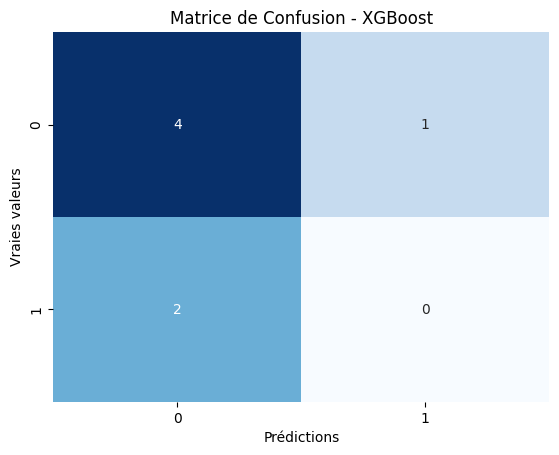

In [28]:
# Afficher la matrice de confusion avec seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion - XGBoost")
plt.show()

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)

In [31]:
# Afficher l'accuracy
print('Accuracy : {:.2f}%'.format(accuracy * 100))

Accuracy : 57.14%


# Test avec DATA augmentation

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [33]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(
    images_train,
    labels_train,
    batch_size=32,
)

val_generator = datagen.flow(
    images_test,
    labels_test,
    batch_size=32,
)

In [34]:
X_aug, y_aug = train_generator.next()

In [35]:
X_aug.shape

(32, 50, 50, 3)

In [36]:
X_aug = X_aug.reshape(X_aug.shape[0], -1)

In [37]:
X_aug.shape

(32, 7500)

In [38]:
XPCA_aug = pca.fit_transform(X_aug)

In [39]:
bst = XGBClassifier(n_estimators=150, max_depth=3, objective='binary:logistic')

In [40]:
Y_aug = y_aug
Y_aug[Y_aug != 1] = 0
X_train, X_test, y_train, y_test = train_test_split(XPCA_aug,Y_aug, test_size=0.2)
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
learningScoreXGB = bst.score(X_train, y_train)
generalizationScoreXGB = bst.score(X_test, y_test)
print('Learning score For XGBOOST: '+str(learningScoreXGB))
print('Generalization score For XGBOOST: '+str(generalizationScoreXGB))

Learning score For XGBOOST: 1.0
Generalization score For XGBOOST: 0.7142857142857143


# Enregistrement du model

In [42]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [43]:
import joblib 
joblib.dump(bst, 'boosting.joblib')

['boosting.joblib']